# Normalize S2 data using NEON as a reference
step1: prepare S2 data: open S2 safe file in PCI and open 20m bands and export to a tiff file (PCI inlcuding 10m B2,3,4 in 20m as well) (not in the code)<br>
step2: subset 20m S2 using NEON 10m band as a reference using PCI<br>
step3: using GDAL the resampling method to generate 60m data for S2 and NEON in order to smooth the images<br>
step4: using NEON 60m data as the reference and S2 as input to generate linear coefficents using stats.theilslopes<br>
step5: read S2 20m file and normalizing and genereate 20m normalized S2<br>
step6: generate a 20m NEON data using GDAL average resamling method for the comparsion of the normalized S2<br>
step7: verify the normalized result through ploting normalized S2 and NEON 20,  RMSE, SSIM and R2_score.<br>
Next step: using DSen2 to process normalized S2 data (Not Done)

In [1]:
# from scipy import interpolate
import numpy as np
import pandas as pd
from osgeo import gdal, osr
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from datetime import datetime
from sklearn.metrics import mean_squared_error 
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import r2_score

In [2]:
S2_file='F:\\neon\\normalization\\S2_20m_UNDE.tif'
S2_file_60m='F:\\neon\\normalization\\S2_60m_UNDE.tif'

In [3]:
raster_rprj = gdal.Warp(S2_file_60m, S2_file, xRes=60, yRes=60, resampleAlg = "average")
raster_rprj = None

In [4]:
NEON_file='F:\\neon\\normalization\\NEON_D05_UNDE_DP1_20190606_184411_reflectance_10m.tif'
NEON_file_60m='F:\\neon\\normalization\\NEON_60m_UNDE.tif'
NEON_file_20m='F:\\neon\\normalization\\NEON_20m_UNDE.tif'

In [5]:
raster_rprj = gdal.Warp(NEON_file_60m, NEON_file, xRes=60, yRes=60, resampleAlg = "average")
raster_rprj = None

In [6]:
ds_S2_60m = gdal.Open(S2_file_60m)
ds_NEON_60m = gdal.Open(NEON_file_60m)
print (ds_S2_60m.RasterCount)
print (ds_NEON_60m.RasterCount)
print (ds_S2_60m.GetDescription())
print (ds_NEON_60m.GetDescription())

9
16
F:\neon\normalization\S2_60m_UNDE.tif
F:\neon\normalization\NEON_60m_UNDE.tif


In [7]:
bands_S2 = {ds_S2_60m.GetRasterBand(i).GetDescription(): i for i in range(1, ds_S2_60m.RasterCount + 1)}
bands_NEON = {ds_NEON_60m.GetRasterBand(i).GetDescription(): i for i in range(1, ds_NEON_60m.RasterCount + 1)}
print (bands_S2)
print (bands_NEON)

{'Sentinel-2 Blue (0.457 - 0.523) um': 1, 'Sentinel-2 Green (0.542 - 0.578) um': 2, 'Sentinel-2 Red (0.650 - 0.680) um': 3, 'Sentinel-2 Vegetation Red Edge 1 (0.697 - 0.713) um': 4, 'Sentinel-2 Vegetation Red Edge 2 (0.732 - 0.748) um': 5, 'Sentinel-2 Vegetation Red Edge 3 (0.773 - 0.793) um': 6, 'Sentinel-2 NIR (0.855 - 0.875) um': 7, 'Sentinel-2 SWIR-1 (1.565 - 1.655) um': 8, 'Sentinel-2 SWIR-2 (2.100 - 2.280) um': 9}
{'': 16}


In [ ]:
# S2 1-B2 2-B3 3-B4 4-B5 5-B6 6-B7 7-B8A 8-B11 9-B12
# NEON 1-B1 2-B2, 3-B3, 4-B4 5-B5 6-B6 7-B7 8-B8 9-B8A 10-B9 11-B10 12-B11 13-B12

# band by band to generate linear regression coefficents and check the stats for each band 

In [8]:
#B3
S2_B3=np.array(ds_S2_60m.GetRasterBand(2).ReadAsArray())
NEON_B3=np.array(ds_NEON_60m.GetRasterBand(3).ReadAsArray())

S2_B3 = np.where(S2_B3==-9999, np.nan, S2_B3)
NEON_B3 = np.where(NEON_B3==-9999, np.nan, NEON_B3)
S2_B3=S2_B3/10000

mask = ~np.isnan(S2_B3) & ~np.isnan(NEON_B3)
NEON_B3_mask = NEON_B3[mask]
S2_B3_mask = S2_B3[mask]
# scipy.stats.theilslopes(y, x=None, alpha=0.95, method='separate')
# Method to be used for computing estimate for intercept. Following methods are supported,
# ‘joint’: Uses np.median(y - slope * x) as intercept.
# ‘separate’: Uses np.median(y) - slope * np.median(x) as intercept.
# The default is ‘separate’.
# B3_reg = stats.theilslopes(S2_B3_mask, NEON_B3_mask, 0.90, 'joint')
B3_reg = stats.theilslopes(NEON_B3_mask,S2_B3_mask, 0.90, 'joint')

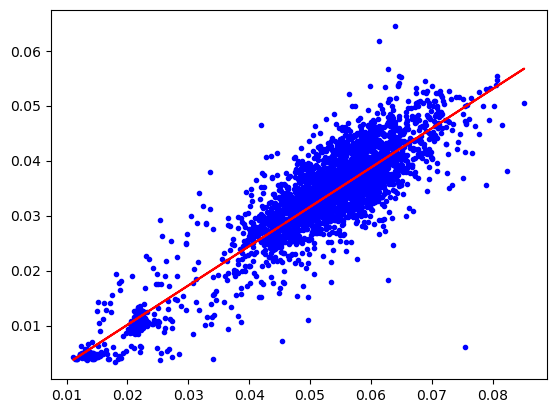

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot( NEON_B3_mask, S2_B3_mask, 'b.')
# ax.plot( NEON_B3_mask, B3_reg[1] +B3_reg[0] * NEON_B3_mask, 'r-')
ax.plot(S2_B3_mask,NEON_B3_mask, 'b.')
ax.plot(S2_B3_mask, B3_reg[1] +B3_reg[0] *  S2_B3_mask, 'r-')
plt.show()

In [10]:
# def rmse(predictions, targets):
#     return np.sqrt(((predictions - targets) ** 2).mean())

In [10]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B3_mask,S2_B3_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B3_mask,S2_B3_mask,data_range=(S2_B3_mask.max()-S2_B3_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
# R2 = r2_score(S2_B3_mask, NEON_B3_mask)
R2 = r2_score(NEON_B3_mask,S2_B3_mask)
print (RMSE)
print (SSIM)
print (R2)

0.01908487156338815
0.577807307887448
-1.9579749644440985


In [12]:
# print (rmse(S2_B3_mask, NEON_B3_mask))
# print (mean_squared_error(S2_B3_mask, NEON_B3_mask, squared=False) )

In [11]:
#B4
S2_B4=np.array(ds_S2_60m.GetRasterBand(3).ReadAsArray())
NEON_B4=np.array(ds_NEON_60m.GetRasterBand(4).ReadAsArray())

S2_B4 = np.where(S2_B4==-9999, np.nan, S2_B4)
NEON_B4 = np.where(NEON_B4==-9999, np.nan, NEON_B4)
S2_B4=S2_B4/10000

mask = ~np.isnan(S2_B4) & ~np.isnan(NEON_B4)
NEON_B4_mask = NEON_B4[mask]
S2_B4_mask = S2_B4[mask]
B4_reg = stats.theilslopes(NEON_B4_mask,S2_B4_mask, 0.90, 'joint')

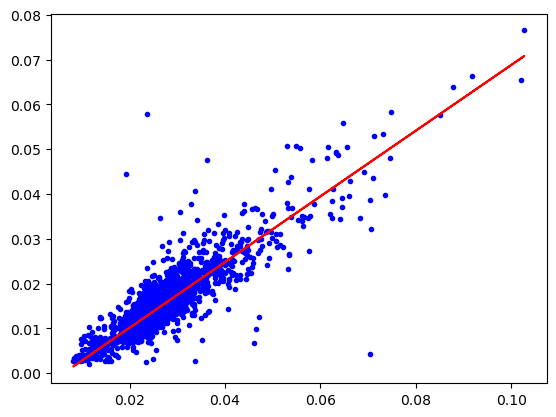

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(  S2_B4_mask,NEON_B4_mask, 'b.')
ax.plot(  S2_B4_mask,B4_reg[1] +B4_reg[0] * S2_B4_mask, 'r-')
plt.show()

In [12]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B4_mask,S2_B4_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B4_mask,S2_B4_mask,data_range=(S2_B4_mask.max()-S2_B4_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
R2 = r2_score(NEON_B4_mask,S2_B4_mask)
print (RMSE)
print (SSIM)
print (R2)

0.011714923514838662
0.6727116703295343
-1.560304064788078


In [13]:
#B5
S2_B5=np.array(ds_S2_60m.GetRasterBand(4).ReadAsArray())
NEON_B5=np.array(ds_NEON_60m.GetRasterBand(5).ReadAsArray())

S2_B5 = np.where(S2_B5==-9999, np.nan, S2_B5)
NEON_B5 = np.where(NEON_B5==-9999, np.nan, NEON_B5)
S2_B5=S2_B5/10000

mask = ~np.isnan(S2_B5) & ~np.isnan(NEON_B5)
NEON_B5_mask = NEON_B5[mask]
S2_B5_mask = S2_B5[mask]
B5_reg = stats.theilslopes(NEON_B5_mask,S2_B5_mask, 0.90, 'joint')

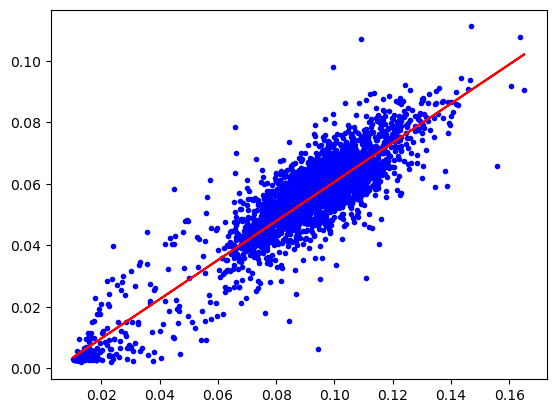

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( S2_B5_mask,NEON_B5_mask, 'b.')
ax.plot( S2_B5_mask, B5_reg[1] +B5_reg[0] * S2_B5_mask, 'r-')
plt.show()

In [15]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B5_mask,S2_B5_mask, squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B5_mask,S2_B5_mask,data_range=(S2_B5_mask.max()-S2_B5_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
R2 = r2_score(NEON_B5_mask,S2_B5_mask)
print (RMSE)
print (SSIM)
print (R2)

0.035315291484773526
0.6043675853567831
-1.8772616608266897


In [16]:
#B6
S2_B6=np.array(ds_S2_60m.GetRasterBand(5).ReadAsArray())
NEON_B6=np.array(ds_NEON_60m.GetRasterBand(6).ReadAsArray())

S2_B6 = np.where(S2_B6==-9999, np.nan, S2_B6)
NEON_B6 = np.where(NEON_B6==-9999, np.nan, NEON_B6)
S2_B6=S2_B6/10000

mask = ~np.isnan(S2_B6) & ~np.isnan(NEON_B6)
NEON_B6_mask = NEON_B6[mask]
S2_B6_mask = S2_B6[mask]
B6_reg = stats.theilslopes(NEON_B6_mask,S2_B6_mask, 0.90, 'joint')

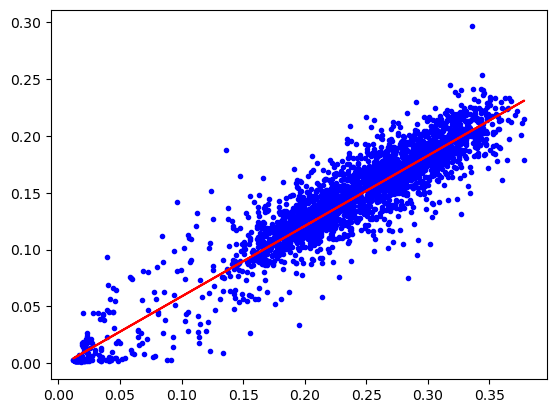

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( S2_B6_mask, NEON_B6_mask, 'b.')
ax.plot( S2_B6_mask, B6_reg[1] +B6_reg[0] * S2_B6_mask, 'r-')
plt.show()

In [18]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B6_mask,S2_B6_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B6_mask,S2_B6_mask,data_range=(S2_B6_mask.max()-S2_B6_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
R2 = r2_score(NEON_B6_mask,S2_B6_mask)
print (RMSE)
print (SSIM)
print (R2)

0.09328382874355563
0.6318040364315823
-1.4021051619207516


In [19]:
#B7
S2_B7=np.array(ds_S2_60m.GetRasterBand(6).ReadAsArray())
NEON_B7=np.array(ds_NEON_60m.GetRasterBand(7).ReadAsArray())

S2_B7 = np.where(S2_B7==-9999, np.nan, S2_B7)
NEON_B7 = np.where(NEON_B7==-9999, np.nan, NEON_B7)
S2_B7=S2_B7/10000

mask = ~np.isnan(S2_B7) & ~np.isnan(NEON_B7)
NEON_B7_mask = NEON_B7[mask]
S2_B7_mask = S2_B7[mask]
B7_reg = stats.theilslopes(NEON_B7_mask,S2_B7_mask, 0.90, 'joint')

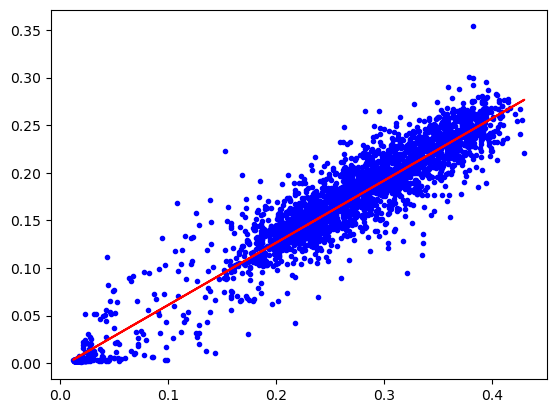

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( S2_B7_mask,NEON_B7_mask, 'b.')
ax.plot( S2_B7_mask,B7_reg[1] +B7_reg[0] * S2_B7_mask, 'r-')
plt.show()

In [21]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B7_mask,S2_B7_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B7_mask,S2_B7_mask,data_range=(S2_B7_mask.max()-S2_B7_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
R2 = r2_score(NEON_B7_mask,S2_B7_mask)
print (RMSE)
print (SSIM)
print (R2)

0.09727711451831658
0.6636905953355093
-0.7998954295412337


In [22]:
#B8A
S2_B8A=np.array(ds_S2_60m.GetRasterBand(7).ReadAsArray())
NEON_B8A=np.array(ds_NEON_60m.GetRasterBand(9).ReadAsArray())

S2_B8A = np.where(S2_B8A==-9999, np.nan, S2_B8A)
NEON_B8A = np.where(NEON_B8A==-9999, np.nan, NEON_B8A)
S2_B8A=S2_B8A/10000

mask = ~np.isnan(S2_B8A) & ~np.isnan(NEON_B8A)
NEON_B8A_mask = NEON_B8A[mask]
S2_B8A_mask = S2_B8A[mask]
B8A_reg = stats.theilslopes(NEON_B8A_mask,S2_B8A_mask, 0.90, 'joint')

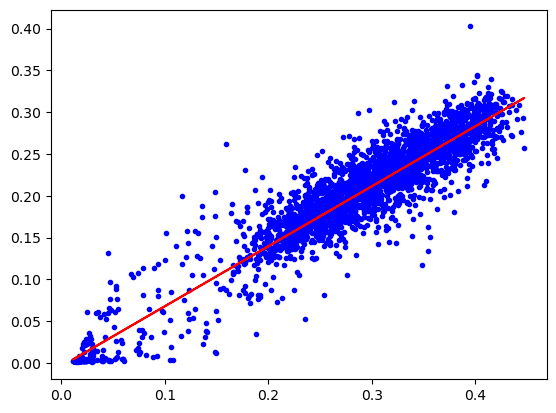

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( S2_B8A_mask,NEON_B8A_mask, 'b.')
ax.plot( S2_B8A_mask,B8A_reg[1] +B8A_reg[0] * S2_B8A_mask, 'r-')
plt.show()

In [24]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B8A_mask,S2_B8A_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B8A_mask,S2_B8A_mask,data_range=(S2_B8A_mask.max()-S2_B8A_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
R2 = r2_score(NEON_B8A_mask,S2_B8A_mask)
print (RMSE)
print (SSIM)
print (R2)

0.08548647840649805
0.6958849866351234
-0.03391648245215051


In [25]:
#B11
S2_B11=np.array(ds_S2_60m.GetRasterBand(8).ReadAsArray())
NEON_B11=np.array(ds_NEON_60m.GetRasterBand(12).ReadAsArray())

S2_B11 = np.where(S2_B11==-9999, np.nan, S2_B11)
NEON_B11 = np.where(NEON_B11==-9999, np.nan, NEON_B11)
S2_B11=S2_B11/10000

mask = ~np.isnan(S2_B11) & ~np.isnan(NEON_B11)
NEON_B11_mask = NEON_B11[mask]
S2_B11_mask = S2_B11[mask]
B11_reg = stats.theilslopes(NEON_B11_mask,S2_B11_mask, 0.90, 'joint')

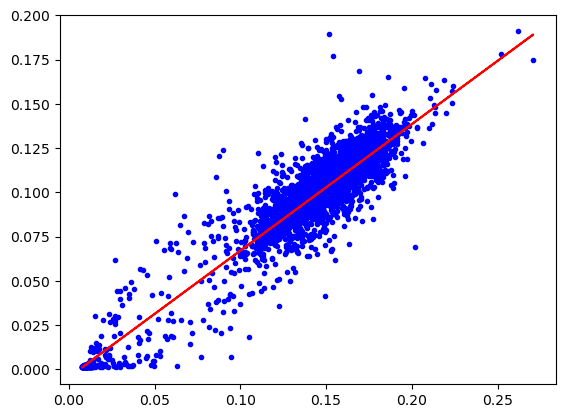

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( S2_B11_mask,NEON_B11_mask, 'b.')
ax.plot( S2_B11_mask,B11_reg[1] +B11_reg[0] * S2_B11_mask, 'r-')
plt.show()

In [27]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B11_mask, S2_B11_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B11_mask,S2_B11_mask,data_range=(S2_B11_mask.max()-S2_B11_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
R2 = r2_score(NEON_B11_mask,S2_B11_mask)
# R2 = r2_score(NEON_B11_mask,S2_B11_mask)
print (RMSE)
print (SSIM)
print (R2)

0.0450886381538485
0.6842118946216291
-0.36751993011061024


In [28]:
print (S2_B11_mask)

[0.1241 0.1277 0.1103 ... 0.145  0.1389 0.1233]


In [29]:
print (NEON_B11_mask)

[0.09015241 0.07925919 0.0695323  ... 0.1012723  0.09744978 0.08256025]


In [30]:
# np.savetxt('S2_B11.csv',S2_B11_mask)
# np.savetxt('NEON_B11.csv',NEON_B11_mask)

In [31]:
#B12
S2_B12=np.array(ds_S2_60m.GetRasterBand(9).ReadAsArray())
NEON_B12=np.array(ds_NEON_60m.GetRasterBand(13).ReadAsArray())

S2_B12 = np.where(S2_B12==-9999, np.nan, S2_B12)
NEON_B12 = np.where(NEON_B12==-9999, np.nan, NEON_B12)
S2_B12=S2_B12/10000

mask = ~np.isnan(S2_B12) & ~np.isnan(NEON_B12)
NEON_B12_mask = NEON_B12[mask]
S2_B12_mask = S2_B12[mask]
B12_reg = stats.theilslopes(NEON_B12_mask,S2_B12_mask, 0.90, 'joint')

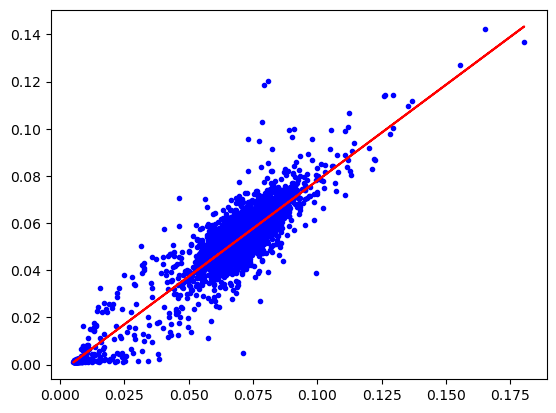

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( S2_B12_mask,NEON_B12_mask, 'b.')
ax.plot( S2_B12_mask, B12_reg[1] +B12_reg[0] * S2_B12_mask, 'r-')
plt.show()

In [36]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B12_mask,S2_B12_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B12_mask,S2_B12_mask,data_range=(S2_B12_mask.max()-S2_B12_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
R2 = r2_score(NEON_B12_mask,S2_B12_mask)
# R2 = r2_score(NEON_B12_mask,S2_B12_mask)
print (RMSE)
print (SSIM)
print (R2)

0.016647887890511165
0.7276328345086637
0.35984379069095773


# Normalization

In [196]:
# S2 1-B2 2-B3 3-B4 4-B5 5-B6 6-B7 7-B8A 8-B11 9-B12

In [95]:
# ds_NEON_10m = gdal.Open(NEON_file)
ds_S2_20m = gdal.Open(S2_file)

In [96]:
def CreateGeoTiff(Name, Array, driver, NDV, 
                  GeoT, Projection, DataType):
    Array[np.isnan(Array)] = NDV
    # DataSet = driver.Create(Name, Array.shape[2], Array.shape[1], Array.shape[0], DataType)
    # DataSet = driver.Create(Name, Array.shape[1], Array.shape[0], Array.shape[2], DataType)  ## col, row, bands
    DataSet = driver.Create(Name, Array.shape[2], Array.shape[1], Array.shape[0], DataType)  ## col, row, bands
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection( Projection.ExportToWkt() )
    # for i in range(Array.shape[2]):
    for i in range(Array.shape[0]):       
        # DataSet.GetRasterBand(i+1).WriteArray(Array[:,:,i] )
        DataSet.GetRasterBand(i+1).WriteArray(Array[i,:,:] )
        DataSet.GetRasterBand(i+1).SetNoDataValue(NDV)
    DataSet.FlushCache()
    return Name

In [97]:
prj=ds_S2_20m.GetProjection()
# print (prj)
srs=osr.SpatialReference(wkt=prj)
# print (srs)
geotransform = ds_S2_20m.GetGeoTransform()
# print (geotransform)

In [98]:
bands=ds_S2_20m.RasterCount 
width=ds_S2_20m.RasterXSize 
height=ds_S2_20m.RasterYSize 
print (bands, width, height)

9 73 771


In [107]:
S2_B= np.empty([bands, height, width], dtype=float)
# print (S22.shape)

In [108]:
# Sim_Output=np.zeros(shape=(S2_Bands,Ref_shape[0],Ref_shape[1]))

# for i in range(1, ds_NEON_10m.RasterCount + 1):
#     NEON_B[i]=np.array(ds_NEON_10m.GetRasterBand(i).ReadAsArray())
# print (NEON_B.shape)
S2_B = np.array(ds_S2_20m.ReadAsArray())
print (S2_B.shape)

(9, 771, 73)


In [109]:
# print (S2_B.type())

In [40]:
# print (B3_reg)

In [41]:
# NEON_B[2] = np.where(NEON_B[2]==-9999, np.nan, NEON_B[2])
# # mask =  ~np.isnan(NEON_B[2])
# print (NEON_B[2])

In [42]:
# np.savetxt('S2_B1.csv',S2_B[1])

In [43]:
# S2_B[1] = np.where(S2_B[1]==-9999, np.nan, S2_B[1])
# # S2_B[1]=B3_reg[1]+B3_reg[0]*S2_B[1]/10000.0
# S2_B[1]=B3_reg[1]*10000+B3_reg[0]*S2_B[1]

In [44]:
# np.savetxt('S2_B1_norm.csv',S2_B[1])

In [110]:
print( S2_B[8].max())
print( S2_B[7].max())
print( S2_B[5].max())

2071
3104
4792


In [102]:
print (B12_reg)
print (B11_reg)
print (B7_reg)

TheilslopesResult(slope=0.8132379305990117, intercept=-0.003309355656567363, low_slope=0.8050340742842311, high_slope=0.8214755499430292)
TheilslopesResult(slope=0.7146768217539265, intercept=-0.004401714354923442, low_slope=0.7086936700142036, high_slope=0.7206929754887231)
TheilslopesResult(slope=0.6530349692995402, intercept=-0.004202324931186094, low_slope=0.6479877558108288, high_slope=0.6579930803417104)


In [71]:
# S2_B[5]=B7_reg[1]*10000.0+B7_reg[0]*S2_B[5]

In [76]:
# print( S2_B[5].max())

65528


In [93]:
# print (np.where(S2_B[5]==65528))

(array([461], dtype=int64), array([9], dtype=int64))


In [94]:
# print (S2_B[5][0])

[1452 1465 1382 1363 1263 1299 1420 1473 1336 1309 1293 1352 1480 1372
 1364 1505 1843 2107 2285 2003 1820 1821 1774 1653 1825 1960 1531 1418
 1528 1562 1478 1697 1933 1711 1670 1535 1433 1341 1536 1555 1493 1443
 1322 1175 1186 1158 1078 1074 1035  940  976 1236 1336 1322 1765 2107
 1915 1619 1389 1341 1370 1485 1647 1775 1801 1486 1798 1607 1457 1340
 1280 1315 1299]


In [47]:
# NEON_B[2]=B3_reg[1] +B3_reg[0] * NEON_B[2]
# print (NEON_B[2])

In [111]:
# S2_B[2]=np.array(ds_NEON_10m.GetRasterBand(3).ReadAsArray())
# S2_B[1] = np.where(S2_B[1]==-9999, np.nan, S2_B[1])
S2_B[1]=B3_reg[1]*10000.0+B3_reg[0]*S2_B[1]
S2_B[1] = np.where(S2_B[1]>60000, 0.0, S2_B[1])

# S2_B4=np.array(ds_NEON_10m.GetRasterBand(4).ReadAsArray())
# S2_B[2] = np.where(S2_B[2]==-9999, np.nan, S2_B[2])
S2_B[2]=B4_reg[1]*10000.0+B4_reg[0]*S2_B[2]
S2_B[2] = np.where(S2_B[2]>60000, 0.0, S2_B[2])

# S2_B5=np.array(ds_NEON_10m.GetRasterBand(5).ReadAsArray())
# S2_B[3] = np.where(S2_B[3]==-9999, np.nan, S2_B[3])
S2_B[3]=B5_reg[1]*10000.0+B5_reg[0]*S2_B[3]
S2_B[3] = np.where(S2_B[3]>60000, 0.0, S2_B[3])

# S2_B6=np.array(ds_NEON_10m.GetRasterBand(6).ReadAsArray())
# S2_B[4] = np.where(S2_B[4]==-9999, np.nan, S2_B[4])
S2_B[4]=B6_reg[1]*10000.0+B6_reg[0]*S2_B[4]
S2_B[4] = np.where(S2_B[4]>60000, 0.0, S2_B[4])

# # S2_B7=np.array(ds_NEON_10m.GetRasterBand(7).ReadAsArray())
# # S2_B[5] = np.where(S2_B[5]==-9999, np.nan, S2_B[5])
S2_B[5]=B7_reg[1]*10000.0+B7_reg[0]*S2_B[5]
S2_B[5] = np.where(S2_B[5]>60000, 0.0, S2_B[5])

# # S2_B8A=np.array(ds_NEON_10m.GetRasterBand(9).ReadAsArray())
# # S2_B[6] = np.where(S2_B[6]==-9999, np.nan, S2_B[6])
S2_B[6]=B8A_reg[1]*10000.0+B8A_reg[0]*S2_B[6]
S2_B[6] = np.where(S2_B[6]>60000, 0.0, S2_B[6])

# S2_B11=np.array(ds_NEON_10m.GetRasterBand(12).ReadAsArray())
# S2_B[7] = np.where(S2_B[7]==-9999, np.nan, S2_B[7])
S2_B[7]=B11_reg[1]*10000.0+B11_reg[0]*S2_B[7]
S2_B[7] = np.where(S2_B[7]>60000, 0.0, S2_B[7])

# S2_B12=np.array(ds_NEON_10m.GetRasterBand(13).ReadAsArray())
# S2_B[8] = np.where(S2_B[8]==-9999, np.nan, S2_B[8])
S2_B[8]=B12_reg[1]*10000.0+B12_reg[0]*S2_B[8]
S2_B[8] = np.where(S2_B[8]>60000, 0.0, S2_B[8])

In [113]:
file_norm='F:\\neon\\normalization\\S2_20m_UNDE_norm.tif'
data_type = gdal.GDT_Float32
driver = gdal.GetDriverByName('GTiff')
CreateGeoTiff(file_norm, S2_B, driver, -9999, geotransform, srs, data_type)

'F:\\neon\\normalization\\S2_20m_UNDE_norm.tif'

In [ ]:
# NEON 1-B1 2-B2, 3-B3, 4-B4 5-B5 6-B6 7-B7 8-B8 9-B8A 10-B9 11-B10 12-B11 13-B12¶

## Test normalization result

In [115]:
## generate 20 m neon data
raster_rprj = gdal.Warp(NEON_file_20m, NEON_file, xRes=20, yRes=20, resampleAlg = "average")
raster_rprj = None

In [120]:
S2_file_20m='F:\\neon\\normalization\\S2_20m_UNDE_norm.tif'
ds_S2_20m = gdal.Open(S2_file_20m)
ds_NEON_20m = gdal.Open(NEON_file_20m)
print (ds_S2_20m.RasterCount)
print (ds_NEON_20m.RasterCount)
print (ds_S2_20m.GetDescription())
print (ds_NEON_20m.GetDescription())

9
16
F:\neon\normalization\S2_20m_UNDE_norm.tif
F:\neon\normalization\NEON_20m_UNDE.tif


In [121]:
#B3
S2_B3=np.array(ds_S2_20m.GetRasterBand(2).ReadAsArray())
NEON_B3=np.array(ds_NEON_20m.GetRasterBand(3).ReadAsArray())

S2_B3 = np.where(S2_B3==-9999, np.nan, S2_B3)
NEON_B3 = np.where(NEON_B3==-9999, np.nan, NEON_B3)
# S2_B3=S2_B3/10000

# mask = ~np.isnan(S2_B3) & ~np.isnan(NEON_B3)
# NEON_B3_mask = NEON_B3[mask]
# S2_B3_mask = S2_B3[mask]


In [122]:
print (S2_B3.shape)
print (NEON_B3.shape)

(771, 73)
(770, 71)


In [123]:
# make a new S2_B3 array with the same size of NENON
S2_B3_2=S2_B3[:NEON_B3.shape[0],:NEON_B3.shape[1]]

In [124]:
mask = ~np.isnan(S2_B3_2) & ~np.isnan(NEON_B3)
NEON_B3_mask = NEON_B3[mask]
S2_B3_mask = S2_B3_2[mask]/10000

In [125]:
print (NEON_B3_mask)
print (NEON_B3_mask.max())

[0.02363405 0.023067   0.03364698 ... 0.04661895 0.03132052 0.01853883]
0.10323718


In [126]:
print (S2_B3_mask)
print (S2_B3_mask.max())

[0.0264 0.0244 0.026  ... 0.0314 0.0334 0.03  ]
0.0924


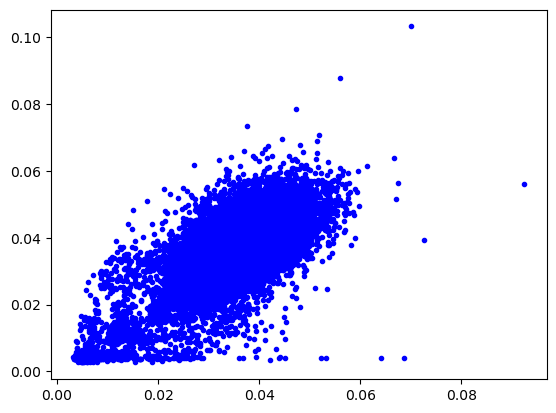

In [127]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot( NEON_B3_mask, S2_B3_mask, 'b.')
# ax.plot( NEON_B3_mask, B3_reg[1] +B3_reg[0] * NEON_B3_mask, 'r-')
ax.plot(S2_B3_mask,NEON_B3_mask, 'b.')
# ax.plot(S2_B3_mask, B3_reg[1] +B3_reg[0] *  S2_B3_mask, 'r-')
plt.show()

In [11]:
# def rmse(predictions, targets):
#     return np.sqrt(((predictions - targets) ** 2).mean())

In [128]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B3_mask,S2_B3_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B3_mask,S2_B3_mask,data_range=(S2_B3_mask.max()-S2_B3_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
# R2 = r2_score(S2_B3_mask, NEON_B3_mask)
R2 = r2_score(NEON_B3_mask,S2_B3_mask)
print (RMSE)
print (SSIM)
print (R2)

0.0062480653
0.5276808672944127
0.7250876360529482


In [129]:
# print (rmse(S2_B3_mask, NEON_B3_mask))
# print (mean_squared_error(S2_B3_mask, NEON_B3_mask, squared=False) )

In [130]:
#B4
S2_B4=np.array(ds_S2_20m.GetRasterBand(3).ReadAsArray())
NEON_B4=np.array(ds_NEON_20m.GetRasterBand(4).ReadAsArray())

S2_B4 = np.where(S2_B4==-9999, np.nan, S2_B4)
NEON_B4 = np.where(NEON_B4==-9999, np.nan, NEON_B4)
# S2_B3=S2_B3/10000

# mask = ~np.isnan(S2_B3) & ~np.isnan(NEON_B3)
# NEON_B3_mask = NEON_B3[mask]
# S2_B3_mask = S2_B3[mask]


In [131]:
print (S2_B4.shape)
print (NEON_B4.shape)

(771, 73)
(770, 71)


In [132]:
# make a new S2_B3 array with the same size of NENON
S2_B4_2=S2_B4[:NEON_B4.shape[0],:NEON_B4.shape[1]]

In [133]:
mask = ~np.isnan(S2_B4_2) & ~np.isnan(NEON_B4)
NEON_B4_mask = NEON_B4[mask]
S2_B4_mask = S2_B4_2[mask]/10000

In [134]:
print (NEON_B4_mask)
print (NEON_B4_mask.max())

[0.01238156 0.01036208 0.01253623 ... 0.02065193 0.01569962 0.01011587]
0.10198901


In [135]:
print (S2_B4_mask)
print (S2_B4_mask.max())

[0.0135 0.0122 0.0138 ... 0.0146 0.0151 0.0132]
0.0881


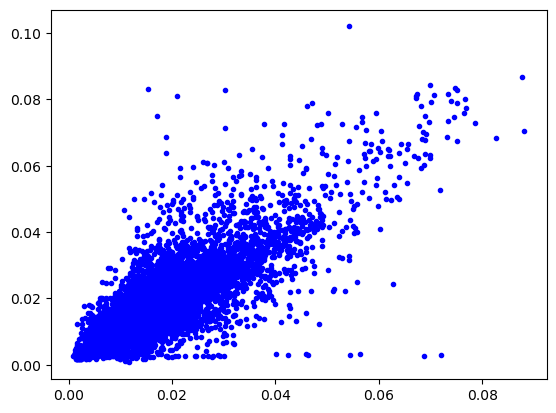

In [136]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot( NEON_B3_mask, S2_B3_mask, 'b.')
# ax.plot( NEON_B3_mask, B3_reg[1] +B3_reg[0] * NEON_B3_mask, 'r-')
ax.plot(S2_B4_mask,NEON_B4_mask, 'b.')
# ax.plot(S2_B3_mask, B3_reg[1] +B3_reg[0] *  S2_B3_mask, 'r-')
plt.show()

In [137]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B4_mask,S2_B4_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B4_mask,S2_B4_mask,data_range=(S2_B4_mask.max()-S2_B4_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
# R2 = r2_score(S2_B3_mask, NEON_B3_mask)
R2 = r2_score(NEON_B4_mask,S2_B4_mask)
print (RMSE)
print (SSIM)
print (R2)

0.0045670285
0.6888333579346566
0.6987959018241048


In [148]:
#B5
S2_B5=np.array(ds_S2_20m.GetRasterBand(4).ReadAsArray())
NEON_B5=np.array(ds_NEON_20m.GetRasterBand(5).ReadAsArray())

S2_B5 = np.where(S2_B5==-9999, np.nan, S2_B5)
NEON_B5 = np.where(NEON_B5==-9999, np.nan, NEON_B5)
# S2_B4=S2_B4/10000

# mask = ~np.isnan(S2_B4) & ~np.isnan(NEON_B4)
# NEON_B4_mask = NEON_B4[mask]
# S2_B4_mask = S2_B4[mask]
# B4_reg = stats.theilslopes(NEON_B4_mask,S2_B4_mask, 0.90, 'joint')

In [149]:
# make a new S2_B3 array with the same size of NENON
S2_B5_2=S2_B5[:NEON_B5.shape[0],:NEON_B5.shape[1]]

In [150]:
mask = ~np.isnan(S2_B5_2) & ~np.isnan(NEON_B5)
NEON_B5_mask = NEON_B5[mask]
S2_B5_mask = S2_B5_2[mask]/10000


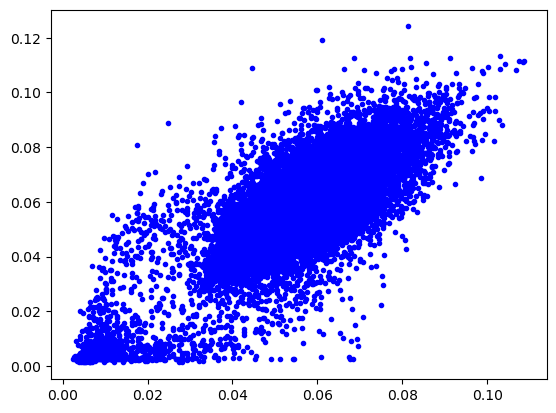

In [151]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(  S2_B5_mask,NEON_B5_mask, 'b.')
# ax.plot(  S2_B4_mask,B4_reg[1] +B4_reg[0] * S2_B4_mask, 'r-')
plt.show()

In [152]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B5_mask,S2_B5_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B5_mask,S2_B5_mask,data_range=(S2_B5_mask.max()-S2_B5_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
R2 = r2_score(NEON_B5_mask,S2_B5_mask)
print (RMSE)
print (SSIM)
print (R2)

0.009716301
0.5190714163196621
0.8085709834135324


In [153]:
#B6
S2_B6=np.array(ds_S2_20m.GetRasterBand(5).ReadAsArray())
NEON_B6=np.array(ds_NEON_20m.GetRasterBand(6).ReadAsArray())

S2_B6 = np.where(S2_B6==-9999, np.nan, S2_B6)
NEON_B6 = np.where(NEON_B6==-9999, np.nan, NEON_B6)
# S2_B3=S2_B3/10000

# mask = ~np.isnan(S2_B3) & ~np.isnan(NEON_B3)
# NEON_B3_mask = NEON_B3[mask]
# S2_B3_mask = S2_B3[mask]


In [155]:
# make a new S2_B3 array with the same size of NENON
S2_B6_2=S2_B6[:NEON_B6.shape[0],:NEON_B6.shape[1]]

In [156]:
mask = ~np.isnan(S2_B6_2) & ~np.isnan(NEON_B6)
NEON_B6_mask = NEON_B6[mask]
S2_B6_mask = S2_B6_2[mask]/10000

In [157]:
print (NEON_B6_mask)
print (NEON_B6_mask.max())

[0.11385801 0.11374053 0.14811972 ... 0.18708763 0.12307495 0.07756939]
0.32360268


In [158]:
print (S2_B6_mask)
print (S2_B6_mask.max())

[0.1206 0.1111 0.1241 ... 0.1346 0.1351 0.1314]
0.2568


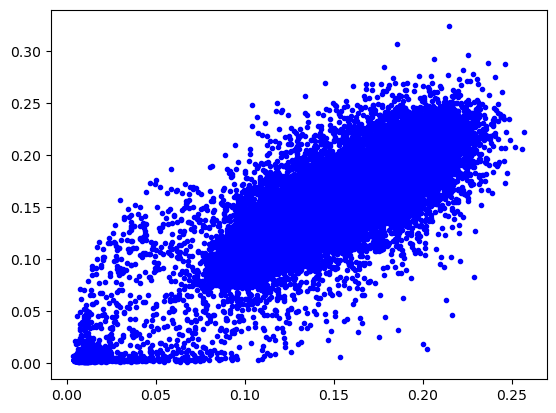

In [159]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot( NEON_B3_mask, S2_B3_mask, 'b.')
# ax.plot( NEON_B3_mask, B3_reg[1] +B3_reg[0] * NEON_B3_mask, 'r-')
ax.plot(S2_B6_mask,NEON_B6_mask, 'b.')
# ax.plot(S2_B3_mask, B3_reg[1] +B3_reg[0] *  S2_B3_mask, 'r-')
plt.show()

In [160]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B6_mask,S2_B6_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B6_mask,S2_B6_mask,data_range=(S2_B6_mask.max()-S2_B6_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
# R2 = r2_score(S2_B3_mask, NEON_B3_mask)
R2 = r2_score(NEON_B6_mask,S2_B6_mask)
print (RMSE)
print (SSIM)
print (R2)

0.025545934
0.5084009261776112
0.8394284128360276


In [161]:
#B7
S2_B7=np.array(ds_S2_20m.GetRasterBand(6).ReadAsArray())
NEON_B7=np.array(ds_NEON_20m.GetRasterBand(7).ReadAsArray())

S2_B7 = np.where(S2_B7==-9999, np.nan, S2_B7)
NEON_B7 = np.where(NEON_B7==-9999, np.nan, NEON_B7)
# S2_B3=S2_B3/10000

# mask = ~np.isnan(S2_B3) & ~np.isnan(NEON_B3)
# NEON_B3_mask = NEON_B3[mask]
# S2_B3_mask = S2_B3[mask]


In [162]:
print (S2_B7.shape)
print (NEON_B7.shape)

(771, 73)
(770, 71)


In [163]:
# make a new S2_B3 array with the same size of NENON
S2_B7_2=S2_B7[:NEON_B7.shape[0],:NEON_B7.shape[1]]

In [164]:
mask = ~np.isnan(S2_B7_2) & ~np.isnan(NEON_B7)
NEON_B7_mask = NEON_B7[mask]
S2_B7_mask = S2_B7_2[mask]/10000

In [165]:
print (NEON_B7_mask)
print (NEON_B7_mask.max())

[0.14165951 0.14197233 0.17634135 ... 0.22681363 0.14898597 0.09612674]
0.37872


In [166]:
print (S2_B7_mask)
print (S2_B7_mask.max())

[0.1433 0.1341 0.1536 ... 0.1614 0.1689 0.1537]
0.3003


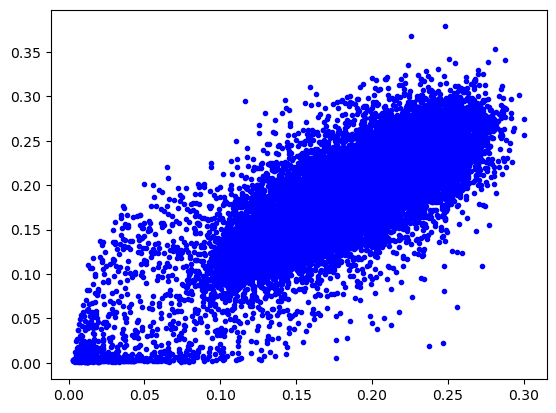

In [167]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot( NEON_B3_mask, S2_B3_mask, 'b.')
# ax.plot( NEON_B3_mask, B3_reg[1] +B3_reg[0] * NEON_B3_mask, 'r-')
ax.plot(S2_B7_mask,NEON_B7_mask, 'b.')
# ax.plot(S2_B3_mask, B3_reg[1] +B3_reg[0] *  S2_B3_mask, 'r-')
plt.show()

In [168]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B7_mask,S2_B7_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B7_mask,S2_B7_mask,data_range=(S2_B7_mask.max()-S2_B7_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
# R2 = r2_score(S2_B3_mask, NEON_B3_mask)
R2 = r2_score(NEON_B7_mask,S2_B7_mask)
print (RMSE)
print (SSIM)
print (R2)

0.030110449
0.5183878945511097
0.8457103676755855


In [169]:
#B8A
S2_B8A=np.array(ds_S2_20m.GetRasterBand(7).ReadAsArray())
NEON_B8A=np.array(ds_NEON_20m.GetRasterBand(9).ReadAsArray())

S2_B8A = np.where(S2_B8A==-9999, np.nan, S2_B8A)
NEON_B8A = np.where(NEON_B8A==-9999, np.nan, NEON_B8A)
# S2_B3=S2_B3/10000

# mask = ~np.isnan(S2_B3) & ~np.isnan(NEON_B3)
# NEON_B3_mask = NEON_B3[mask]
# S2_B3_mask = S2_B3[mask]


In [170]:
print (S2_B8A.shape)
print (NEON_B8A.shape)

(771, 73)
(770, 71)


In [171]:
# make a new S2_B3 array with the same size of NENON
S2_B8A_2=S2_B8A[:NEON_B8A.shape[0],:NEON_B8A.shape[1]]

In [172]:
mask = ~np.isnan(S2_B8A_2) & ~np.isnan(NEON_B8A)
NEON_B8A_mask = NEON_B8A[mask]
S2_B8A_mask = S2_B8A_2[mask]/10000

In [173]:
print (NEON_B8A_mask)
print (NEON_B8A_mask.max())

[0.16927321 0.16983962 0.20871331 ... 0.2672381  0.17712364 0.11625149]
0.434381


In [174]:
print (S2_B8A_mask)
print (S2_B8A_mask.max())

[0.1735 0.1645 0.1764 ... 0.188  0.1899 0.1865]
0.3442


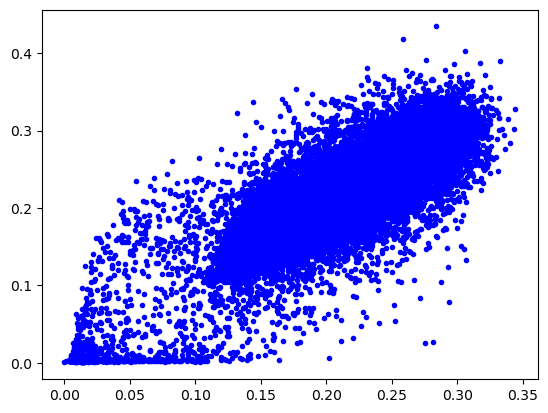

In [175]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot( NEON_B3_mask, S2_B3_mask, 'b.')
# ax.plot( NEON_B3_mask, B3_reg[1] +B3_reg[0] * NEON_B3_mask, 'r-')
ax.plot(S2_B8A_mask,NEON_B8A_mask, 'b.')
# ax.plot(S2_B3_mask, B3_reg[1] +B3_reg[0] *  S2_B3_mask, 'r-')
plt.show()

In [177]:
#B11
S2_B11=np.array(ds_S2_20m.GetRasterBand(8).ReadAsArray())
NEON_B11=np.array(ds_NEON_20m.GetRasterBand(12).ReadAsArray())

S2_B11 = np.where(S2_B11==-9999, np.nan, S2_B11)
NEON_B11 = np.where(NEON_B11==-9999, np.nan, NEON_B11)
# S2_B3=S2_B3/10000

# mask = ~np.isnan(S2_B3) & ~np.isnan(NEON_B3)
# NEON_B3_mask = NEON_B3[mask]
# S2_B3_mask = S2_B3[mask]


In [178]:
print (S2_B11.shape)
print (NEON_B11.shape)

(771, 73)
(770, 71)


In [181]:
# # make a new S2_B3 array with the same size of NENON
# S2_B4_2=S2_B4[:NEON_B4.shape[0],:NEON_B4.shape[1]]

# NEON_B11_2=NEON_B11[:S2_B11.shape[0],:S2_B11.shape[1]]
S2_B11_2=S2_B11[:NEON_B11.shape[0],:NEON_B11.shape[1]]

In [183]:
mask = ~np.isnan(S2_B11_2) & ~np.isnan(NEON_B11)
NEON_B11_mask = NEON_B11[mask]
S2_B11_mask = S2_B11_2[mask]/10000

In [184]:
print (NEON_B11_mask)
print (NEON_B11_mask.max())

[0.07702623 0.07543901 0.11146789 ... 0.10946413 0.08243062 0.05494069]
0.23464584


In [185]:
print (S2_B11_mask)
print (S2_B11_mask.max())

[0.081  0.0759 0.0843 ... 0.0802 0.0835 0.0839]
0.2174


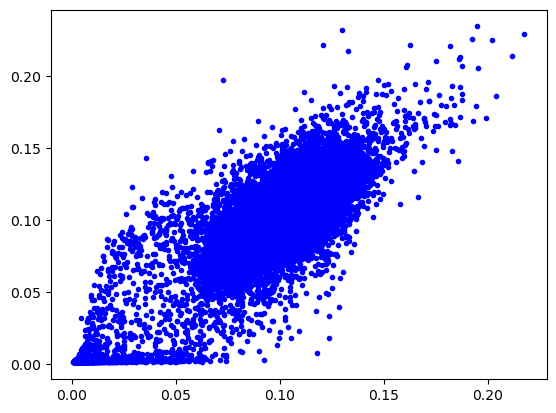

In [186]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot( NEON_B3_mask, S2_B3_mask, 'b.')
# ax.plot( NEON_B3_mask, B3_reg[1] +B3_reg[0] * NEON_B3_mask, 'r-')
ax.plot(S2_B11_mask,NEON_B11_mask, 'b.')
# ax.plot(S2_B3_mask, B3_reg[1] +B3_reg[0] *  S2_B3_mask, 'r-')
plt.show()

In [11]:
# def rmse(predictions, targets):
#     return np.sqrt(((predictions - targets) ** 2).mean())

In [187]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B11_mask,S2_B11_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B11_mask,S2_B11_mask,data_range=(S2_B11_mask.max()-S2_B11_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
# R2 = r2_score(S2_B3_mask, NEON_B3_mask)
R2 = r2_score(NEON_B11_mask,S2_B11_mask)
print (RMSE)
print (SSIM)
print (R2)

0.015917934
0.5740301547469467
0.8491389391710409


In [188]:
#B12
S2_B12=np.array(ds_S2_20m.GetRasterBand(9).ReadAsArray())
NEON_B12=np.array(ds_NEON_20m.GetRasterBand(13).ReadAsArray())

S2_B12 = np.where(S2_B12==-9999, np.nan, S2_B12)
NEON_B12 = np.where(NEON_B12==-9999, np.nan, NEON_B12)
# S2_B3=S2_B3/10000

# mask = ~np.isnan(S2_B3) & ~np.isnan(NEON_B3)
# NEON_B3_mask = NEON_B3[mask]
# S2_B3_mask = S2_B3[mask]


In [189]:
print (S2_B12.shape)
print (NEON_B12.shape)

(771, 73)
(770, 71)


In [190]:
# # make a new S2_B3 array with the same size of NENON
# S2_B4_2=S2_B4[:NEON_B4.shape[0],:NEON_B4.shape[1]]

# NEON_B12_2=NEON_B12[:S2_B12.shape[0],:S2_B12.shape[1]]
S2_B12_2=S2_B12[:NEON_B12.shape[0],:NEON_B12.shape[1]]

In [191]:
mask = ~np.isnan(S2_B12_2) & ~np.isnan(NEON_B12)
NEON_B12_mask = NEON_B12[mask]
S2_B12_mask = S2_B12_2[mask]/10000

In [192]:
print (NEON_B12_mask)
print (NEON_B12_mask.max())

[0.03966623 0.03793148 0.05954668 ... 0.05403231 0.04272998 0.02817584]
0.18046436


In [193]:
print (S2_B12_mask)
print (S2_B12_mask.max())

[0.0458 0.0393 0.0458 ... 0.04   0.0427 0.0437]
0.1651


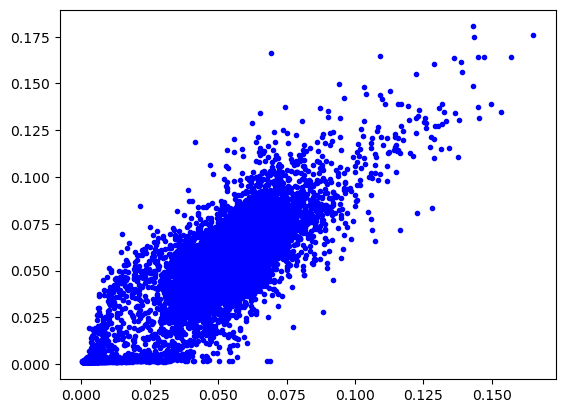

In [194]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot( NEON_B3_mask, S2_B3_mask, 'b.')
# ax.plot( NEON_B3_mask, B3_reg[1] +B3_reg[0] * NEON_B3_mask, 'r-')
ax.plot(S2_B12_mask,NEON_B12_mask, 'b.')
# ax.plot(S2_B3_mask, B3_reg[1] +B3_reg[0] *  S2_B3_mask, 'r-')
plt.show()

In [11]:
# def rmse(predictions, targets):
#     return np.sqrt(((predictions - targets) ** 2).mean())

In [195]:
#RMSE
# mean_squared_error(y_actual, y_predicted, squared=False)
RMSE = mean_squared_error(NEON_B12_mask,S2_B12_mask,squared=False) 
## ssim
# skimage.metrics.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)
SSIM = ssim(NEON_B12_mask,S2_B12_mask,data_range=(S2_B12_mask.max()-S2_B12_mask.min())) 
## R2
# sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
# R2 = r2_score(S2_B3_mask, NEON_B3_mask)
R2 = r2_score(NEON_B12_mask,S2_B12_mask)
print (RMSE)
print (SSIM)
print (R2)

0.009624148
0.616449523963158
0.8164559537269411
